In [1]:
import numpy as np
import pandas as pd

# For tokenization
from nltk.tokenize import TweetTokenizer
# For lemmatization
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
# For cleaning 
import re, string
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import backend as K
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


# *Loading and exploring data:*

In [2]:
# Loading the data to a data frame
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", header=None)

# Adding labels to the data
df.columns = ['label', 'time', 'date', 'query', 'user', 'tweet']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1600000 non-null  int64 
 1   time    1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   tweet   1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [3]:
df.head()

,label,time,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Checking the data's balance: 0=negative 4=positive
df['label'].value_counts()

4    800000
0    800000
Name: label, dtype: int64

Training the model with all the 1600000 data objects takes a long time even with a GPU so we only use a third of the data

In [5]:
df_pos = df[df['label'] == 4]
df_neg = df[df['label'] == 0]
print(len(df_pos), len(df_neg))

800000 800000


In [6]:
df_pos = df_pos.iloc[:int(len(df_pos)/1)]
df_neg = df_neg.iloc[:int(len(df_neg)/1)]
print(len(df_pos), len(df_neg))

800000 800000


In [7]:
# putting positive and negative rows together
df = pd.concat([df_pos, df_neg])
len(df)

1600000

In [8]:
# We only need label and the tweet, so other columns are dropped
df = df.drop(['time', 'date', 'query', 'user'], axis=1)
df.head()

,label,tweet
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


# *Data Preprocessing:*
1. Cleaning
2. Tokenization
3. Lemmatization

**1.Cleaning:**
In this section I only implement the functions needed to clean the data.
We will actually use these functions in the Tokenization section. Also in our vectors we don't have '. for exapmle we don't have "i'm" but we have "im".

In [9]:
def clean(token):
    
    """Converting the common abbreviations and misspellings
    to their formal and correct form"""
    
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        # Remove the '
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    
    else: return token

In [10]:
def remove_noise(tokens):
    
    """Uses clean() function and removes links, mentions and
    stop words from the list of tokens it is given"""
    
    en_stopwords = stopwords.words('english')
    cleaned_tokens = []
    
    for token in tokens:
        # remove the token if it's a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # remove the token if it's a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        # Cleans the token with clean() function
        cleaned_token = clean(token)
        
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        # Returns the token only if it's not a stopword or a punctuation or has more than 2 characters
        # there were a lot one character meaningless tokens in cleaned tokens so we only take tokens with more than 2 characters
        if cleaned_token not in en_stopwords and cleaned_token not in string.punctuation and len(cleaned_token) > 2:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

**2.Tokenizing:**
We are also using the noise_remove() function in this section so if you are using all the 1600000 training example and running the process on a cpu, it can take a relatively long time for this process to finish up

In [11]:
# Tokenization --> We use TweetTokenizer from nltk --> Then we put the tokenized sentences and their labels in data
# reduce_len argument will allow a maximum of 3 repeating characters and trims the rest (e.g: helloooooo -> hellooo)
tk = TweetTokenizer(reduce_len=True)

# Separating labels from tweets (as lists)
X = df['tweet'].tolist()
Y = df['label'].tolist()

# Building a list of tuples called data. Each tuple is a pair of tokenized words and It's label as 0/1
data = []

for x, y in zip(X, Y):
    if y == 4:
        data.append((remove_noise(tk.tokenize(x)), 1))
    elif y == 0:
        data.append((remove_noise(tk.tokenize(x)), 0))

In [12]:
# Viewing a value from the data list (no stop word, link, mention or common abbreviation and tokenized)
data[100]

(['determined',
  'get',
  'back',
  'baseball',
  'it',
  'is',
  'years',
  'since',
  "I've",
  'really',
  'watched',
  'sport',
  'Anyone',
  'interested',
  'going',
  'game'],
 1)

**3.Lemmatization:**

In [13]:
# Lemmatization --> We use WordNetLemmatizer that takes two inputs: list of tokens and their part of speech (i.e verb, noun, etc...)
# To get the tokens' part of speech we use nltk's post_tag function. It takes in a list of tokens and gives us a list of tuples of 
# tokens and their part of speech pairs. Position tags are explained in:
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html


def lemmatize_sentence(tokens):
    
    """ Takes in a list of tokens, generates the position tags for them
    and lemmatizes the tokens using WordNetTokenizer function """
    
    lemmatized_sentence = []
    lemmatizer = WordNetLemmatizer()
    
    for word, tag in pos_tag(tokens):
        # Converting pos_tag output tags to the tags WordNetTokenizer can interpret
        if tag.startswith('N'):
            # It's a noun
            pos = wordnet.NOUN
        elif tag.startswith('V'):
            # It's a verb
            pos = wordnet.VERB
        elif tag.startswith('J'):
            # It's an adjective
            pos = wordnet.ADJ
        else:
            # Otherwise we take it as an adverb (starts with 'R')
            pos = wordnet.ADV
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    
    return lemmatized_sentence

index = 100
print('original setence: ', data[index][0], '\n')
print('A Preview of the pos_tag function output:\n', pos_tag(data[index][0]), '\n')
print('lemmatized sentence:\n', lemmatize_sentence(data[index][0]), '\n')

original setence:  ['determined', 'get', 'back', 'baseball', 'it', 'is', 'years', 'since', "I've", 'really', 'watched', 'sport', 'Anyone', 'interested', 'going', 'game'] 

A Preview of the pos_tag function output:
 [('determined', 'VBN'), ('get', 'VB'), ('back', 'RB'), ('baseball', 'NN'), ('it', 'PRP'), ('is', 'VBZ'), ('years', 'NNS'), ('since', 'IN'), ("I've", 'NNP'), ('really', 'RB'), ('watched', 'VBD'), ('sport', 'NN'), ('Anyone', 'NNP'), ('interested', 'VBD'), ('going', 'VBG'), ('game', 'NN')] 

lemmatized sentence:
 ['determine', 'get', 'back', 'baseball', 'it', 'be', 'year', 'since', "I've", 'really', 'watch', 'sport', 'Anyone', 'interest', 'go', 'game'] 



Now we can use the lemmatize_sentence() function that we wrote to lemmatize all the texts in the dataset (which takes a VERY long time to finish):

In [14]:
# Lemmatizing the whole data
final_data = []
for i in range(len(data)):
    final_data.append((lemmatize_sentence(data[i][0]), data[i][1]))

In [15]:
final_data[100][0]

['determine',
 'get',
 'back',
 'baseball',
 'it',
 'be',
 'year',
 'since',
 "I've",
 'really',
 'watch',
 'sport',
 'Anyone',
 'interest',
 'go',
 'game']

# Data visualization

Frequent words: 


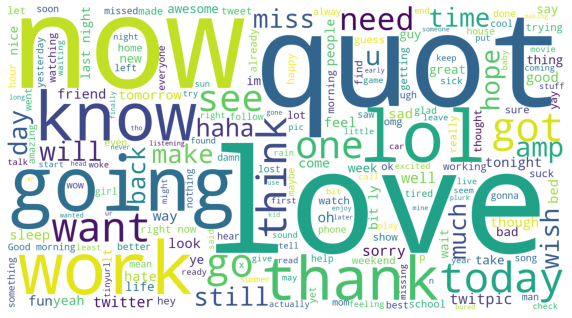

In [16]:
def wordcloud_draw(data, color = 'white'):
    
    cloud = WordCloud(stopwords = STOPWORDS,
                          background_color = color,
                          width = 1980,
                          height = 1080
                         ).generate(' '.join(data))
    plt.figure(1, figsize = (10, 10))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

print('Frequent words: ')
visualize_data = df['tweet']
wordcloud_draw(visualize_data)


# *GloVe (Global Vector for words):*

In [17]:
!ls

__notebook__.ipynb


In [18]:
# Downloading GloVe word embeddings from stanford's website
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-04-27 05:46:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-27 05:46:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-27 05:46:10--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [19]:
# Unzipping GloVe
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [20]:
# Defining a function to load GloVe files -->
# Take a look at glove file format if needed
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf8') as file:
        # sets don't have duplicate values
        words = set()
        word_to_vec_map = {}
        for line in file:
            line_words = line.strip().split()
            # The first word in each line is the main word
            curr_word = line_words[0]
            words.add(curr_word)
            # The rest of the word is the vector values of the word
            word_to_vec_map[curr_word] = np.array(line_words[1:], dtype=np.float64)
        
        i = 1
        word_to_index = {}
        index_to_word = {}
        for w in sorted(words):
            word_to_index[w] = i
            index_to_word[i] = w
            i = i + 1
        return word_to_index, index_to_word, word_to_vec_map

In [21]:
# Loading the 50D glove file
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [22]:
# Examples of above dictionaries:
print('sentiment:')
print('word to index: ', word_to_index['sentiment'])
print('index 325097 to word: ', index_to_word[325097])
print('word to vec map: ', word_to_vec_map['sentiment'])

sentiment:
word to index:  325097
index 325097 to word:  sentiment
word to vec map:  [-1.2133    -0.90213    0.13794   -0.74039    0.50177   -0.44758
 -0.18016   -0.20015   -0.64463    0.82942    0.33512   -0.80038
  0.0061474 -0.18723   -0.75038    0.38448   -0.50565   -1.0729
 -0.15345   -0.25502    0.47037   -0.09944   -0.039826  -0.54291
  0.50762   -1.1403    -0.59459    0.65168    0.49759    1.3418
  2.181      0.39817    1.2389    -0.80048   -0.992     -1.4046
 -1.0876    -0.85777   -0.58064   -0.61168   -0.81255   -0.4506
 -0.43371   -0.43891    1.0593     0.09786   -0.16378    0.91932
  0.75144   -0.16973  ]


In [23]:
# Defining cosine similarity (answer in range -1 to 1)
# Check out the formula if needed
def cosine_similarity(a, b):
    dot = np.dot(a, b)
    norm_a = np.sqrt(np.sum(a**2))
    norm_b = np.sqrt(np.sum(b**2))
    return dot / (norm_a * norm_b)

In [24]:
# Testing the cosine similarity function:
cosine_similarity(word_to_vec_map['blade'], word_to_vec_map['knife'])

0.699947214104835

# Embedding layer

# Defining a costum Embedding layer:
* We will need the setences_to_indices() to turn each sentence into a list of it's corresponding indices 


In [25]:
final_data[100][0]

['determine',
 'get',
 'back',
 'baseball',
 'it',
 'be',
 'year',
 'since',
 "I've",
 'really',
 'watch',
 'sport',
 'Anyone',
 'interest',
 'go',
 'game']

In [26]:
 # Making a list of each tweet's length
lengths = [len(final_data[i][0]) for i in range(len(final_data))]
# length of the ith tweet
i = 4
print('Length of {}th tweet: {}'.format(i, lengths[i]))

# Finding the length of the longest tweet 
max_len = max(lengths)
print('maximum length of a tweet after preprocessing: ', max_len)

Length of 4th tweet: 2
maximum length of a tweet after preprocessing:  34


In [27]:
def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            # the word is unknown
            index = word_to_index['unk']
        X[i, j] = index

In [28]:
# Initializing X as an array each sentence's indices
X = np.zeros((len(final_data), max_len))
# Initializing Y as an array of each sentence's label
Y = np.zeros((len(final_data), ))

In [29]:
# Filling X with indices and Y with labels
for i, tk_lb in enumerate(final_data):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
# Creating a dataframe of X and Y
xy_df = pd.DataFrame([*zip(X,Y)])
xy_df.columns = ['X', 'Y']
xy_df.head()

,X,Y
0,"[372306.0, 169725.0, 74390.0, 0.0, 0.0, 0.0, 0...",1.0
1,"[239785.0, 269953.0, 372306.0, 361859.0, 37230...",1.0
2,"[372306.0, 372306.0, 46173.0, 372306.0, 160418...",1.0
3,"[372306.0, 330826.0, 302352.0, 97698.0, 184322...",1.0
4,"[133896.0, 141948.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


In [30]:
# Save X and Y to an output file in current directory
# Reminder: We are using 1/3 of data
# xy_df.to_csv(r'final_xy_small.csv', index=False)

In [31]:
# Preview of X and Y first 5 elements
print('X:\n', X[:5])
print('Y:\n', Y[:5])

X:
 [[372306. 169725.  74390.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [239785. 269953. 372306. 361859. 372306. 382320. 372306. 372306.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [372306. 372306.  46173. 372306. 160418. 239785. 372306. 329974.  58999.
  349437.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [372306. 330826. 302352.  97698. 184322. 251645. 132701. 302292. 151204.
  372306. 154049. 231458. 338210.      0.      0.      0.      0.      0.
     

Now that we have access to each word's representing index in each training example (sentence)
We will proceed to build a **model**:
First we make our embedding layer that takes in our sentence's word indices and multiplys it by the weights (corresponding embedding vectors) :

In [32]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    
    """ Creating a Keras Embedding() layer that takes in all the input indices
    and multiply it by corresponding vectors
    to output values in shape of (vocabulary , words's_vectors)
    the weigths are the embedding matrix"""
    
    # Vocab length is the length of our dictionary of unique words plus one (for unk)
    vocab_len = len(word_to_index) + 1
    
    # emb_dim represents the length of a word embedding (= dimension of glove vector (50/100/...))
    emb_dim = word_to_vec_map['random'].shape[0]
    
    # Each row of embedding matrix will store the vector representation of one word for the entire dictionary
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Setting the 'idx'th row of the emb_matrix to the word vector representation of that word 
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    # Creating the Keras embedding layer with vocabulary as input and emb_matrix as output
    # trainable=False will not allow the optimization algorithm to modify the values of the word embeddings (weights)
    embedding_layer = Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False, input_shape=(max_len,))
    
    # Building the embedding layer so that we can set the weights
    embedding_layer.build((None,))
    
    # Setting the weights to the emb_matrix
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

# Defining Model:

In [33]:
model = Sequential()

model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
# return_sequence has to be true because we have another layer (for accessing the hidden state)
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 50)            20000050  
_________________________________________________________________
bidirectional (Bidirectional (None, 34, 256)           183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [34]:
# We use binary_crossentropy loss function because our final output activation is sigmoid
# We use the default adam optimizer and accuracy as our metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
# Spliting the data set
# stratify shuffles the data before spliting
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print('lenght of train set: ', len(X_train))
print('length of test set: ', len(X_test))

lenght of train set:  1280000
length of test set:  320000


## Training the model:
* Use GPU even if you are using 1/64 of the data.

In [36]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=128, shuffle=True)

Epoch 1/20
10000/10000 [==============================] - 161s 15ms/step - loss: 0.5547 - accuracy: 0.7119 - val_loss: 0.5020 - val_accuracy: 0.7528
Epoch 2/20
10000/10000 [==============================] - 153s 15ms/step - loss: 0.4928 - accuracy: 0.7579 - val_loss: 0.4861 - val_accuracy: 0.7637
Epoch 3/20
10000/10000 [==============================] - 155s 15ms/step - loss: 0.4740 - accuracy: 0.7705 - val_loss: 0.4828 - val_accuracy: 0.7663
Epoch 4/20
10000/10000 [==============================] - 155s 16ms/step - loss: 0.4597 - accuracy: 0.7793 - val_loss: 0.4803 - val_accuracy: 0.7677
Epoch 5/20
10000/10000 [==============================] - 155s 16ms/step - loss: 0.4451 - accuracy: 0.7879 - val_loss: 0.4815 - val_accuracy: 0.7677
Epoch 6/20
10000/10000 [==============================] - 156s 16ms/step - loss: 0.4297 - accuracy: 0.7968 - val_loss: 0.4885 - val_accuracy: 0.7673
Epoch 7/20
10000/10000 [==============================] - 155s 15ms/step - loss: 0.4147 - accuracy: 0.8054

# Regularization:
* Since our model is clearly overfitting we are going to add dropout regularization:

In [37]:
# Clearing the previous keras session
keras.backend.clear_session()

model_do = Sequential()

model_do.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_do.add(Dropout(rate=0.3))
model_do.add(Bidirectional(LSTM(units=256, return_sequences=True)))
model_do.add(Dropout(rate=0.5))
model_do.add(Bidirectional(LSTM(units=256, return_sequences=False)))
model_do.add(Dense(units=1, activation='sigmoid'))

model_do.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 50)            20000050  
_________________________________________________________________
dropout (Dropout)            (None, 34, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 34, 512)           628736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 34, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 22,204,211
Trainable params: 2,204,161
Non-trainable params: 20,000,050
____________________________________

In [38]:
model_do.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=2)

In [40]:
model_do.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True, callbacks=[early_stopping])

Epoch 1/20
10000/10000 [==============================] - 274s 27ms/step - loss: 0.5839 - accuracy: 0.6872 - val_loss: 0.5136 - val_accuracy: 0.7447
Epoch 2/20
10000/10000 [==============================] - 265s 26ms/step - loss: 0.5300 - accuracy: 0.7321 - val_loss: 0.4984 - val_accuracy: 0.7554
Epoch 3/20
10000/10000 [==============================] - 264s 26ms/step - loss: 0.5146 - accuracy: 0.7422 - val_loss: 0.4930 - val_accuracy: 0.7585
Epoch 4/20
10000/10000 [==============================] - 264s 26ms/step - loss: 0.5063 - accuracy: 0.7487 - val_loss: 0.4882 - val_accuracy: 0.7631
Epoch 5/20
10000/10000 [==============================] - 267s 27ms/step - loss: 0.5011 - accuracy: 0.7522 - val_loss: 0.4828 - val_accuracy: 0.7657
Epoch 6/20
10000/10000 [==============================] - 264s 26ms/step - loss: 0.4956 - accuracy: 0.7557 - val_loss: 0.4822 - val_accuracy: 0.7671
Epoch 7/20
10000/10000 [==============================] - 263s 26ms/step - loss: 0.4924 - accuracy: 0.7574

# Predicting a single data object

In [41]:
def custom_tweet_to_indices(tweet, max_len):
    
    X = np.zeros((max_len))
    sentence_indices = []
    cleaned_words = lemmatize_sentence(tk.tokenize(tweet))
    
    for j,w in enumerate(cleaned_words):
        try:
            index = word_to_index[w]
        except:
            index = word_to_index['unk']
        sentence_indices.append(index)
        X[j] = index
        
    return X

custom_tweet_to_indices('spending time on model', max_len)

array([339262., 359889., 269798., 247378.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.])

In [42]:
def predict_custom_string(tweet):
    # Convert the tweet into indices
    custom_input = custom_tweet_to_indices(tweet, max_len)
    
    return model_do.predict(np.array([custom_input])).item()

In [43]:
print(predict_custom_string("I love chocolate"))
print(predict_custom_string("I hate chocolate"))

0.9358109831809998
0.09597533196210861


In [44]:
print(predict_custom_string("I Never liked chocolate at all"))
print(predict_custom_string("I have always liked chocolate."))

0.3671606779098511
0.8472325801849365
